# **ACOPF - SLP**

Essential functions are stored inside the pyhton module called **acopf** .       
    acopf.slp - *ModelBuilder* to set up and adjust the ACOPF-LP-approximation   
    acopf.utils - Functions for data import and parameter calculation.   
    

In [1]:
import sys
sys.path.append('../acopf')

In [2]:
%run ../scripts/create_result_directories.py

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import acopf.slp as slp
import acopf.utils as utils
import acopf.config as config

from pathlib import Path

## **Import Data**

Uncomment the test case that should be solved.

In [4]:
#test_case = "WB2"
test_case = "WB5"
#test_case = "case22loop"

test_case_dir = os.path.join(config.test_cases_dir, test_case)

bus_file = os.path.join(test_case_dir, "bus_data.CSV")
branch_file = os.path.join(test_case_dir, "branch_data.CSV")
gen_file = os.path.join(test_case_dir, "gen_data.CSV")
cost_file = os.path.join(test_case_dir, "cost_data.CSV")

data_importer = utils.DataImporter(bus_file, branch_file, gen_file, cost_file)
bus_data = data_importer.import_bus_data()
branch_data = data_importer.import_branch_data()
gen_data = data_importer.import_gen_data()
cost_data = data_importer.import_cost_data()

In [5]:
bus_data

,bus_i,type,Pd,Qd,Gs,Bs,Vmax,Vmin,Qmax,Qmin,Pmax,Pmin,baseMVA,baseKV
0,1,3,0.00,0.0,0,0,1.05,0.95,18,-0.3,50,0,100,345
1,2,1,1.30,0.2,0,0,1.05,0.95,0,0.0,0,0,100,345
2,3,1,1.30,0.2,0,0,1.05,0.95,0,0.0,0,0,100,345
3,4,1,0.65,0.1,0,0,1.05,0.95,0,0.0,0,0,100,345
4,5,2,0.00,0.0,0,0,1.05,0.95,18,-0.3,50,0,100,345


In [6]:
branch_data

,fbus,tbus,r,x,b,Pmax,Imax,baseMVA,baseKV
0,1,2,0.04,0.09,0.00,25,25,100,345
1,1,3,0.05,0.01,0.00,25,25,100,345
2,2,3,0.07,0.09,0.00,25,25,100,345
3,2,4,0.55,0.90,0.45,25,25,100,345
4,3,5,0.55,0.90,0.45,25,25,100,345
5,4,5,0.06,0.10,0.00,25,25,100,345


In [7]:
gen_data

,bus,Qmax,Qmin,Pmax,Pmin,baseMVA,baseKV
0,1,18,-0.3,50,0,100,345
1,5,18,-0.3,50,0,100,345


In [8]:
cost_data

,startup,shutdown,n,c2,c1,c0
0,2,0,3,0,4,0
1,2,0,3,0,1,0


**Data is prepared to fit the algorithm.**   

Important parameters can be adjustet here. E.g.:
+ Number of objective function segments
+ Initial evaluation points
+ Penalty factors
+ Step-size parameters

In [9]:
#############################################
# Data
#############################################

# Structural data
lines = {
    'nm': [(x,y) for x,y in zip(branch_data['fbus'], branch_data['tbus'])],
    'mn': [(y,x) for x,y in zip(branch_data['fbus'], branch_data['tbus'])]
}
buses = bus_data['bus_i'].tolist()
gen_buses = gen_data['bus'].tolist()
n_buses = len(buses)
n_obj_segments = 4

# Base
base_mva = bus_data['baseMVA'][0]
base_kv = bus_data['baseKV'][0]

# Bus data
pn_d = bus_data['Pd'].tolist()
qn_d = bus_data['Qd'].tolist()
gn_shunt = bus_data['Gs'].tolist()
bn_shunt =  bus_data['Bs'].tolist()
v_min = bus_data['Vmin'].tolist()
v_max = bus_data['Vmax'].tolist()
v_max = [1.1]*len(v_min)
p_max = bus_data['Pmax'].tolist()
p_min = bus_data['Pmin'].tolist()
q_max = bus_data['Qmax'].tolist()
q_min = bus_data['Qmin'].tolist()

# Branch data
r = branch_data['r'].tolist()
x = branch_data['x'].tolist()
b_shunt = branch_data['b'].tolist()
g_shunt = [0]*len(b_shunt)
i_max = branch_data['Imax'].tolist()

# Generator data
p_gen_max = gen_data['Pmax'].tolist()
p_gen_min = gen_data['Pmin'].tolist()


#############################################
# Parameters
#############################################
pc = utils.ParameterCalculator()

# Costs
c1 = [c*base_mva for c in cost_data['c1'].tolist()]
c2 = [c*base_mva**2 for c in cost_data['c2'].tolist()]
costs_generators = pc.get_pwl_coefficients(c1, c2, p_gen_min, p_gen_max, n_obj_segments)

# Penalty factors
pn_viol_fac = [2.5*max(c1)]*n_buses
qn_viol_fac = [12.5*max(c1)]*n_buses
vn_viol_fac = [15*max(c1)]*n_buses
ik_viol_fac = [25*max(c1)]*len(lines['nm'])*2

# Step-size parameters
step_size_a = 0.25
step_size_b = 1.5

# Admittance
yk_matrices = pc.get_yk_matrices( r, x, g_shunt, b_shunt)


#############################################
# Initial evaluation points
#############################################

# Flat start initialization 
vnr_eva = [1]*n_buses
vnj_eva = [0]*n_buses
inr_eva = gn_shunt
inj_eva = [0]*n_buses
i_ini_nm = [yk[0].dot(np.array([1,1])) for yk in yk_matrices]
i_ini_mn = [yk[1].dot(np.array([1,1])) for yk in yk_matrices]
i_ini = i_ini_nm+i_ini_mn
ikr_eva = [i.real for i in i_ini]
ikj_eva = [i.imag for i in i_ini]

## **Model Setup**

In [10]:
%%capture

mb = slp.ModelBuilder(n_buses, gen_buses, n_obj_segments, lines)

mb.add_objective(costs_generators, pn_viol_fac, qn_viol_fac, vn_viol_fac, ik_viol_fac)
mb.add_obj_constraints(p_gen_min, p_gen_max)
mb.add_flow_constraints( yk_matrices, gn_shunt, bn_shunt)
mb.add_box_constraints( v_max, i_max)
mb.add_taylor_constraints(vnr_eva, vnj_eva, inr_eva, inj_eva, ikr_eva, ikj_eva, pn_d, qn_d)
mb.add_power_constraints(p_min, p_max, q_min, q_max)
mb.add_iv_constraints(v_min, v_max, i_max)

## **First Iteration**

**Optimization problem is written to files inside the present folder:**

modelit0.lp - Gurobi model after first iteratation.   
solit0.sol - Solution of the first iteration.

In [11]:
#mb.model.setParam('LogFile', 'Gurobi_LogFile')
mb.model.setParam('Threads', 4)

# Default method chooses automatically (e.g. depending on available threads)
#mb.model.setParam('Method', 0) # primal simplex
mb.model.setParam('Method', 1) # dual simplex
#mb.model.setParam('Method', 2) # barrier method

start_time_0 = time.time()
mb.run()
end_time_0 = time.time()
duration_0 = end_time_0-start_time_0

mb.write_model(os.path.join(config.solver_log_dir,"modelit0"))
mb.write_solution(os.path.join(config.solver_log_dir,"solit0"))

Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
Changed value of parameter Method to 1
   Prev: -1  Min: -1  Max: 5  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 4 threads
Optimize a model with 181 rows, 121 columns and 370 nonzeros
Model fingerprint: 0x9e5ce702
Coefficient statistics:
  Matrix range     [4e-01, 2e+01]
  Objective range  [1e+02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 6e+02]
Presolve removed 162 rows and 92 columns
Presolve time: 0.00s
Presolved: 19 rows, 29 columns, 141 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.501660e-01   0.000000e+00      0s
      20    7.8588859e+02   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.01 seconds
Optimal objective  7.858885948e+02


## **Multiple Runs**

Adjust *number_of_runs* to define the maximum number of iterations.

**At the end of the final iteration, model and solutions are written to the files:**   
   modelit(number_of_runs).lp   
   solit(number_of_runs).sol
   

**If some error occurs or the algorithm terminates prematurely (i.e. before reaching the defined number of runs), model and solution of the last valid iteration can be found in:**   
   current_model.lp   
   current_solution.sol   

**If the model of an iteration is likely to be infeasible, gurobi will try to export the Irreducible Inconsistent Subsystem (IIS).**   

**A *gamma_tolerance* is used to prevent errors occurring due to Gurobi's tolerance and the algorithm's calculations (in particular step-size calculations).**   
   "Smaller *gamma_tolerance*" means, that solutions are able to get closer to ACOPF feasibility.   
   **But:** The smaller the tolerance, the more likely conflicts may occur. I.e., Gurobi's tolerance might lead to a negative *gamma* and calculating step size, which includes *log(gamma)*, will throw an error.

In [12]:
number_of_runs = 10
gamma_tolerance = 10**(-12)

############################################################
# Prepare subsequent runs
############################################################
mb.model.setParam('OutputFlag', 0)
write_solution = False
current_run = 0

# Used to explicitly extract the values of the solution in each run.
# This allows extraction of the solution of a previous run even though the model has arleady been adjusted or is infeasible.
pn_extract = []
qn_extract = []
vnr_extract = []
vnj_extract = []
inr_extract = []
inj_extract = []
ikr_extract = []
ikj_extract = []

# Runtime mesurement
end_time = None
start_time = time.time()

############################################################
# Successive linear programming algorithm
############################################################
while current_run < number_of_runs:
    current_run += 1
    mb.write_model(os.path.join(config.solver_log_dir, "current_model"))
    mb.write_solution(os.path.join(config.solver_log_dir, "current_solution"))

    # New evalutaion points
    try:
        vnr_eva_dict = {key: vnr.x for key, vnr in mb.v_n_r.items()}
        vnj_eva_dict = {key: vnj.x for key, vnj in mb.v_n_j.items()}
        inr_eva_dict = {key: inr.x for key, inr in mb.i_n_r.items()}
        inj_eva_dict = {key: inj.x for key, inj in mb.i_n_j.items()}
        ikr_eva_dict = {key: ikr.x for key, ikr in mb.i_k_r.items()}
        ikj_eva_dict = {key: inj.x for key, inj in mb.i_k_j.items()}
        # Value extraction
        pn_extract = [pn.x for pn in mb.p_n.values()]
        qn_extract = [qn.x for qn in mb.q_n.values()]
        vnr_extract = list(vnr_eva_dict.values())
        vnj_extract = list(vnj_eva_dict.values())
        inr_extract = list(inr_eva_dict.values())
        inj_extract = list(inj_eva_dict.values())
        ikr_extract = list(ikr_eva_dict.values())
        ikj_extract = list(ikj_eva_dict.values())
    except AttributeError as aerr:
        print('Iteration', current_run, ': Model might be infeasible: ', aerr)
        mb.write_model(os.path.join(config.solver_log_dir, "infeasible_model"))
        mb.write_iis(os.path.join(
            config.solver_log_dir, "infeasible_model_iis"))
        raise

    # Adjust evaluation points
    vn_updated_keys = pc.update_iv_eva_points(
        vnr_eva_dict, vnj_eva_dict, v_max)
    ik_updated_keys = pc.update_iv_eva_points(
        ikr_eva_dict, ikj_eva_dict, i_max*2)
    v_max_update = bus_data.loc[bus_data.bus_i.isin(vn_updated_keys)].Vmax.tolist()
    ik_max_update = []
    for ij, imax in zip(ikr_eva_dict, i_max*2):
        if ij in ik_updated_keys:
            ik_max_update.append(imax)

    # Cutting planes
    mb.remove_cutting_planes()
    if vn_updated_keys:
        mb.add_voltage_cutting_plane(
            vnr_eva_dict, vnj_eva_dict, v_max_update, vn_updated_keys)
    if ik_updated_keys:
        mb.add_line_current_cutting_plane(
            ikr_eva_dict, ikj_eva_dict, ik_max_update, ik_updated_keys)

    # Update Taylor series
    mb.remove_taylor_constraints()
    mb.add_taylor_constraints(list(vnr_eva_dict.values()), list(vnj_eva_dict.values()), list(inr_eva_dict.values()),
                              list(inj_eva_dict.values()), list(ikr_eva_dict.values()), list(ikj_eva_dict.values()), 
                              pn_d, qn_d)

    # Step-size
    mb.remove_step_size_constraints()
    penalty = mb.penalty.getValue()
    cost = mb.model.getObjective().getValue()
    pn_opt = [pn.x for pn in mb.p_n.values()]
    vnr_opt = [vnr.x for vnr in mb.v_n_r.values()]
    vnj_opt = [vnj.x for vnj in mb.v_n_j.values()]
    inr_opt = [inr.x for inr in mb.i_n_r.values()]
    inj_opt = [inj.x for inj in mb.i_n_j.values()]

    try:
        step_size_limits = pc.get_step_size_limits(
            pn_opt, pn_d, vnr_opt, vnj_opt, inr_opt, inj_opt, v_max, cost, penalty, step_size_a, step_size_b, 
            current_run)
    except ValueError as vaerr:
        print('Iteration', current_run, ': Error occured while calculating step sizes: ', vaerr)
        if pc.gamma[-1] <= gamma_tolerance:
            print("{0} iteration canceled: Gamma less than tolerance".format(current_run))
            print("Tolerance: "+str(gamma_tolerance))
            print("Gamma: "+str(pc.gamma[-1]))
            break
        else:
            print('Tolerance might be too tight')
            raise

    mb.add_step_size_constraints(list(vnr_eva_dict.values()), list(
        vnj_eva_dict.values()), step_size_limits)

    # Output
    if current_run == number_of_runs:
        mb.model.setParam('OutputFlag', 1)
        write_solution = True
    elif pc.gamma[-1] <= gamma_tolerance:
        print("Iteration {0} canceled: Gamma less than tolerance".format(
            current_run))
        print("Tolerance: "+str(gamma_tolerance))
        print("Gamma: "+str(pc.gamma[-1]))
        break

    mb.run()

    if write_solution == True:
        end_time = time.time()
        mb.write_model(os.path.join(config.solver_log_dir, "modelit{0}".format(number_of_runs)))
        mb.write_solution(os.path.join(config.solver_log_dir, "solit{0}".format(number_of_runs)))

# End of algorithm
end_time = time.time()
duration_it = end_time - start_time
duration_all = duration_0 + duration_it

print()
print("Completed", current_run, "SLP iterations:")
print()
print("{0} subsequent runs in {1} seconds.".format(current_run, duration_it))
print("Duaration including initial iteration: {0} seconds".format(duration_all))
print()


Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 4 threads
Optimize a model with 201 rows, 121 columns and 445 nonzeros
Model fingerprint: 0xcdc9282d
Coefficient statistics:
  Matrix range     [6e-02, 2e+01]
  Objective range  [1e+02, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 6e+02]
Presolve removed 189 rows and 99 columns
Presolve time: 0.00s
Presolved: 12 rows, 22 columns, 56 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
       6    1.0488234e+03   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds
Optimal objective  1.048823366e+03

Completed 10 SLP iterations:

10 subsequent runs in 0.1900317668914795 seconds.
Duaration including initial iteration: 0.1990358829498291 seconds



## **Convergence Visualization**

In [13]:
measures_df = pd.DataFrame({
    'gamma': pc.gamma, 'mismatch': pc.mismatch, 'cost': pc.cost, 'penalty': pc.penalty,
    'offer': list(np.array(pc.cost)-np.array(pc.penalty))})
measures_df

,gamma,mismatch,cost,penalty,offer
0,1.337372e-03,1.052433e+00,785.888595,0.000000,785.888595
1,1.562388e-01,7.805549e-01,1296.311967,201.875606,1094.436360
2,4.500980e-05,4.773640e-02,1060.530291,0.000000,1060.530291
3,3.689505e-01,5.157013e-04,1698.740760,626.750928,1071.989832
4,9.393339e-06,9.822082e-03,1045.633428,0.000000,1045.633428
5,3.809343e-01,6.123732e-07,1690.776670,644.074908,1046.701762
6,2.363093e-06,2.467791e-03,1044.303119,0.000000,1044.303119
7,3.841000e-01,5.969491e-08,1695.466285,651.228516,1044.237769
8,3.466486e-01,1.251794e-03,1618.866971,561.177111,1057.689861
9,4.444483e-07,4.660448e-04,1048.591077,0.000000,1048.591077


Step Sizes at bus n in iteration x:

In [14]:
step_size_df = pd.DataFrame(pc.step_size_limits, columns= buses)
step_size_df

,1,2,3,4,5
0,0.348734,0.348734,0.348734,0.348734,0.348734
1,0.129188,0.129188,0.129188,0.129188,0.129188
2,0.003385,0.003385,0.003385,0.003385,0.003385
3,0.038946,0.038946,0.038946,0.038946,0.038946
4,0.000212,0.000212,0.000212,0.000212,0.000212
5,0.019527,0.019527,0.019527,0.019527,0.019527
6,0.000023,0.000023,0.000023,0.000023,0.000023
7,0.011898,0.011898,0.011898,0.011898,0.011898
8,0.009030,0.009030,0.009030,0.009030,0.009030
9,0.000001,0.000001,0.000001,0.000001,0.000001


Each data point represents the value *y* of the corresponding parameter after iteration *x*.

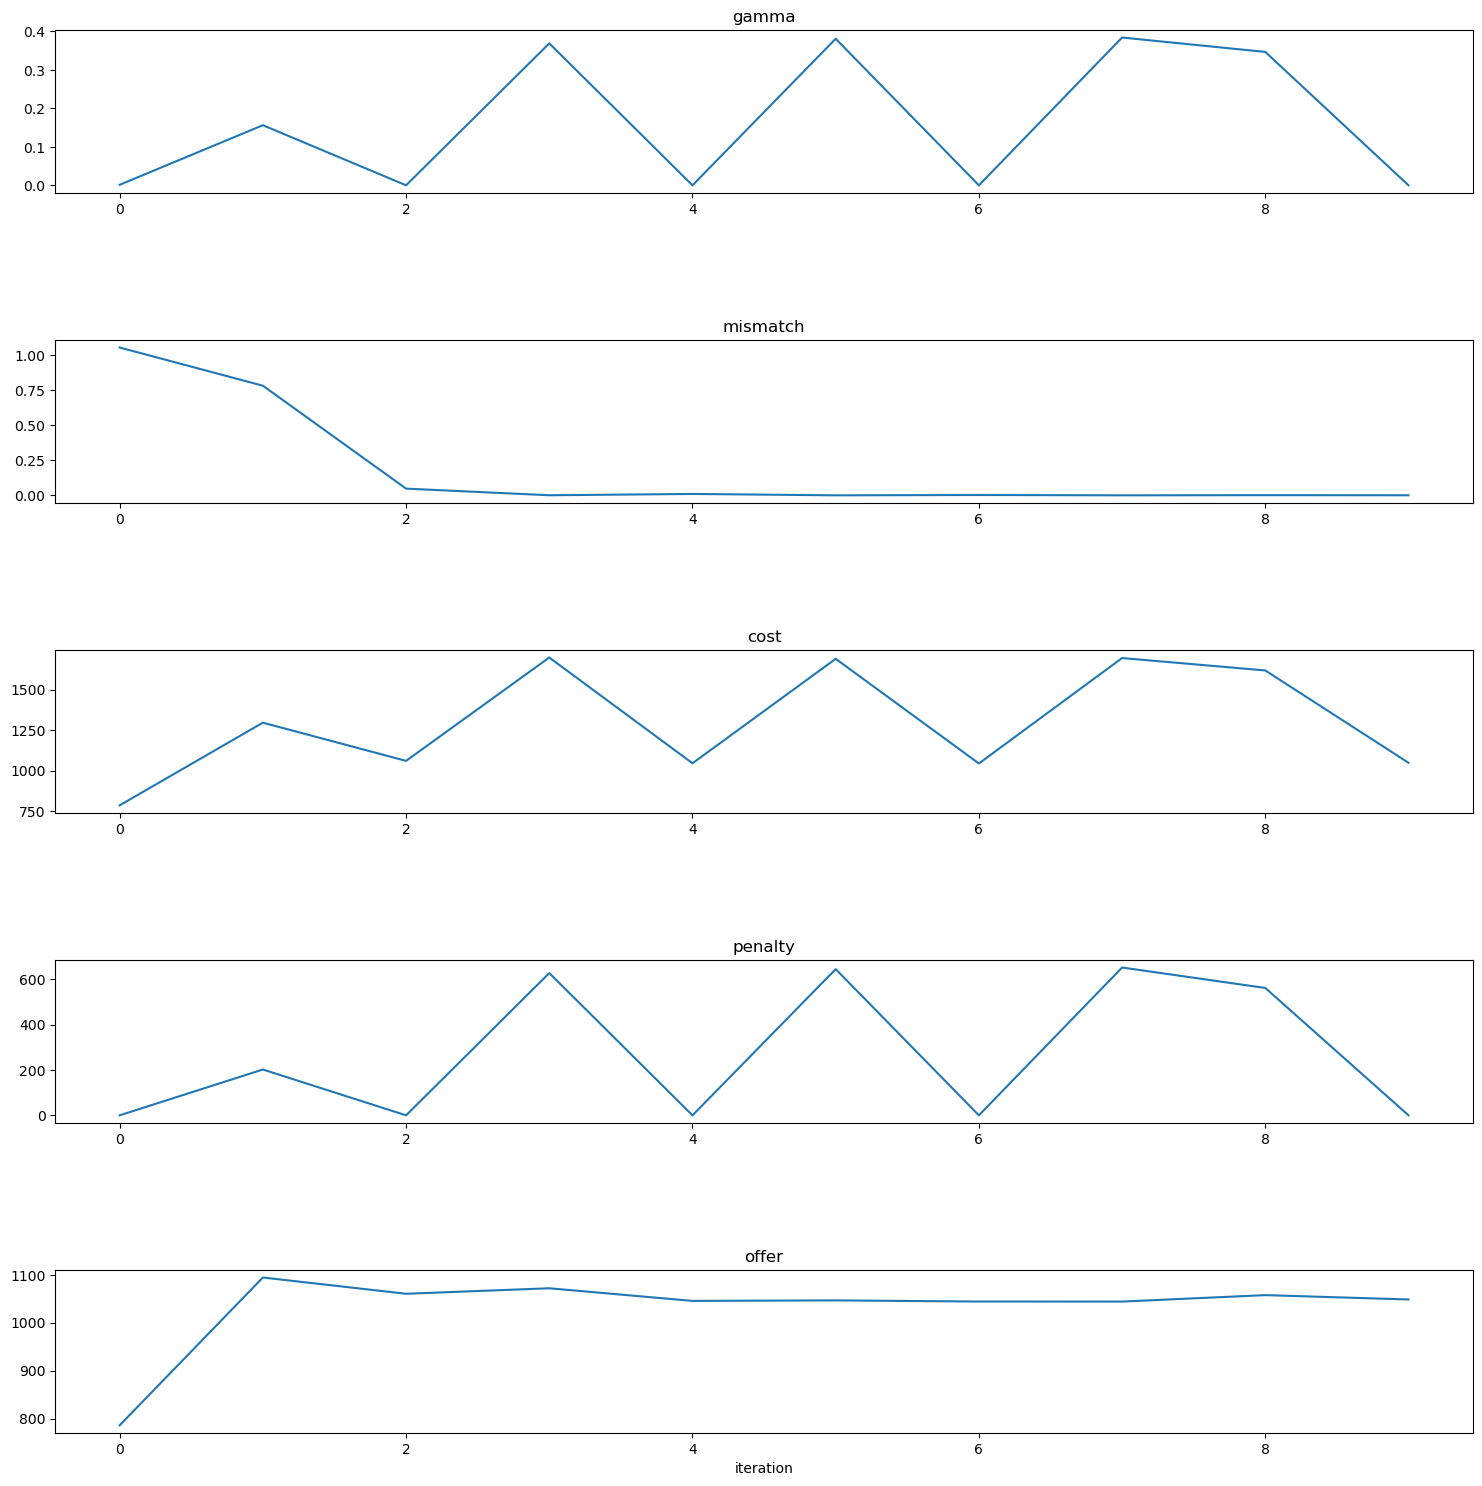

In [15]:
x1 = range(0,len(pc.gamma))
x2 = range(0,len(pc.mismatch))
x3 = range(0,len(pc.cost))
x4 = range(0,len(pc.penalty))
x5 = range(0,len(pc.penalty))

y1 = pc.gamma
y2 = pc.mismatch
y3 = pc.cost
y4 = pc.penalty
y5 = list(np.array(y3)-np.array(y4))

fig, axs = plt.subplots(5, 1)
fig.tight_layout()
fig.set_size_inches(16,16)
plt.xlabel('iteration')

axs[0].plot(x1, y1)
axs[0].set_title('gamma')

axs[1].plot(x2, y2)
axs[1].set_title('mismatch')

axs[2].plot(x3, y3)
axs[2].set_title('cost')

axs[3].plot(x4, y4)
axs[3].set_title('penalty')

axs[4].plot(x5, y5)
axs[4].set_title('offer')

plt.show()


## **Result Organization**

In [16]:
# Power injection
s_magnitude, s_phase =  pc.calc_magnitude_n_phase(pn_extract, qn_extract)
sn_df = pd.DataFrame({'bus': buses, 'magnitude': s_magnitude, 'pn': pn_extract, 'qn': qn_extract, 'phase': s_phase})

# Bus voltages
v_magnitude, v_phase = pc.calc_magnitude_n_phase(vnr_extract, vnj_extract)
vn_df = pd.DataFrame({'bus': buses, 'magnitude': v_magnitude, 'vnr': vnr_extract, 'vnj': vnj_extract, 'phase':v_phase})

# Current flow
ik_magnitude, ik_phase = pc.calc_magnitude_n_phase(ikr_extract, ikj_extract)
ik_df = pd.DataFrame({'lines': lines['nm']+lines['mn'], 'magnitude': ik_magnitude, 'ikr': ikr_extract, 'ikj': ikj_extract, 'phase' : ik_phase})

Power injection:

In [17]:
sn_df

,bus,magnitude,pn,qn,phase
0,1,2.336304,2.332274,0.137159,86.634370
1,2,0.000000,0.000000,0.000000,0.000000
2,3,0.000000,0.000000,0.000000,0.000000
3,4,0.000000,0.000000,0.000000,0.000000
4,5,1.195081,1.156814,-0.300000,-75.461592


Bus voltages:

In [18]:
vn_df

,bus,magnitude,vnr,vnj,phase
0,1,1.017851,0.961768,0.333202,70.891494
1,2,0.954212,0.921184,0.248877,74.881335
2,3,0.950018,0.905302,0.288034,72.350833
3,4,1.057210,0.957976,0.447184,64.976800
4,5,1.096139,0.952659,0.542181,60.354774


Current flow:

In [19]:
ik_df

,lines,magnitude,ikr,ikj,phase
0,"(1, 2)",0.950192,0.949755,-0.028815,-88.262204
1,"(1, 3)",1.418094,1.259611,0.651438,62.653168
2,"(2, 3)",0.370608,-0.185567,-0.320804,30.047031
3,"(2, 4)",0.272695,-0.234615,0.138991,-59.356562
4,"(3, 5)",0.316024,-0.293822,0.116359,-68.395552
5,"(4, 5)",0.815866,-0.675049,-0.458200,55.832698
6,"(2, 1)",0.950192,-0.949755,0.028815,-88.262204
7,"(3, 1)",1.418094,-1.259611,-0.651438,62.653168
8,"(3, 2)",0.370608,0.185567,0.320804,30.047031
9,"(4, 2)",0.294343,0.078001,0.283820,15.367029


## **Export**

In [20]:
export = False

if export:
    now = datetime.now()
    case_date = os.path.join(test_case, now.strftime("%Y%m%d%H%M%S"))
    export_dir = os.path.join(config.solutions_dir, case_date)

    try: 
        Path(export_dir).mkdir(parents=True, exist_ok=False)
    except FileExistsError as e:
        print("Failed to create export directory {0}. Reason: {1}".format(export_dir, e))
        raise  

    measures_df.to_csv(os.path.join(export_dir,"measures.csv"), sep=";")
    step_size_df.to_csv(os.path.join(export_dir, "step-size.csv"), sep=";")
    sn_df.to_csv(os.path.join(export_dir, "power.csv"), sep=";")
    vn_df.to_csv(os.path.join(export_dir, "voltage.csv"), sep=";")
    ik_df.to_csv(os.path.join(export_dir, "current.csv"), sep=";")